In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("Neural Network input_output MinMax") \
    .getOrCreate()

In [2]:
# load the dataset
data = spark.read.csv("GROUP2.csv.gz", header=True, sep=',',inferSchema="true")
data.dtypes

[('groupId', 'string'),
 ('matchId', 'string'),
 ('matchDuration', 'int'),
 ('winPlaceClass', 'int'),
 ('isFirstPerson', 'boolean'),
 ('matchtype', 'int'),
 ('maxPlace', 'int'),
 ('numGroups', 'int'),
 ('hasDisconnected', 'int'),
 ('assist_SUM', 'int'),
 ('assist_MAX', 'int'),
 ('assist_AVG', 'int'),
 ('heals_SUM', 'int'),
 ('heals_MAX', 'int'),
 ('heals_AVG', 'int'),
 ('kills_SUM', 'int'),
 ('kills_MAX', 'int'),
 ('kills_AVG', 'int'),
 ('headshotKills_SUM', 'int'),
 ('headshotKills_MAX', 'int'),
 ('headshotKills_AVG', 'int'),
 ('killStreaks_MAX', 'int'),
 ('roadKills_SUM', 'int'),
 ('roadKills_MAX', 'int'),
 ('roadKills_AVG', 'int'),
 ('longestKill_MAX', 'double'),
 ('vehicleDestroys_MAX', 'int'),
 ('weaponsAcquired_SUM', 'int'),
 ('weaponsAcquired_MAX', 'int'),
 ('weaponsAcquired_AVG', 'int'),
 ('damageDealt_SUM', 'double'),
 ('damageDealt_MAX', 'double'),
 ('damageDealt_AVG', 'double'),
 ('distance_SUM', 'double'),
 ('distance_MAX', 'double'),
 ('distance_AVG', 'double'),
 ('rideDis

In [3]:
from pyspark.sql.functions import col

data = data.withColumn("winPlaceClass", col("winPlaceClass") -1)

In [4]:
inputCols =  data.columns

toRemove = ['matchId', 'groupId', 'killPlace_MAX', 'rankPoints_MAX', 'killPoints_MAX', 'winPoints_MAX', 'winPlaceClass']
inputCols = list(set(inputCols) - set(toRemove))

In [5]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# winPlaceClass

assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")

output = assembler.transform(data)

In [6]:
from pyspark.ml.feature import MinMaxScaler


mm = MinMaxScaler()

mm.setInputCol("features")

model = mm.fit(output)

model.setOutputCol("features_scaled")

MinMaxScalerModel: uid=MinMaxScaler_4ba0cb448374, numFeatures=51, min=0.0, max=1.0

In [7]:
output_scaled = model.transform(output)

In [8]:
seed = 42
withReplacement=False
output_sample = output_scaled.sample(withReplacement, .3, seed).withColumnRenamed("winPlaceClass", "label").select("features_scaled", "label")

(training,testing) = output_sample.randomSplit([0.7,0.3])
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 423568
testing: 181822


In [9]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [10]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd

def customEarlyStoppingNN(blockSize = 128, layers = [], training = None, iterazioni = 10, optimizerIt=5, es = 5):
    (training,validation) = output_sample.randomSplit([0.8,0.2])
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

    
    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []
    models = []
    best_model = 0;
    
    es_count = 0

    for i in range(iterazioni):
        
        trainer = MultilayerPerceptronClassifier(maxIter=optimizerIt, layers=layers, blockSize=blockSize, seed=42)

        if len(models) != 0:
            trainer = trainer.setInitialWeights(models[-1].weights)
        
        model = trainer.fit(training.withColumnRenamed( "features_scaled", "features"))
        
        models.append(model)
        
        trainStat = model.summary()
        
        result = model.transform(validation.withColumnRenamed( "features_scaled", "features"))
        
        evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", probabilityCol="probability")

        evaluator.setMetricName('logLoss')
        logLoss = evaluator.evaluate(result)
        evaluator.setMetricName('accuracy')
        accuracy = evaluator.evaluate(result)
        
        print(F'Epoch {i+1}*{optimizerIt}: loss: {trainStat.objectiveHistory[0]}, acc: {trainStat.accuracy}, val_loss: {logLoss}, val_acc: {accuracy}')
        
        
        if len(loss_val) != 0:
            if loss_val[best_model] < logLoss:
                es_count = es_count +1
            else:
                es_count = 0
                best_model = len(models)-1
            
        if es_count == es:
            print("Early Stopping")
            break
        
        loss_train.append(trainStat.objectiveHistory[0])
        acc_train.append(trainStat.accuracy)
        loss_val.append(logLoss)
        acc_val.append(accuracy)
    
    df = pd.DataFrame()
    
    df["loss_train"] = loss_train
    df["acc_train"] = acc_train
    df["loss_val"] = loss_val
    df["acc_val"] = acc_val
    
    
    return (df, models[best_model])

In [11]:
%%time
df_risultati, model = customEarlyStoppingNN(blockSize = 200, layers = [51, 6], training = training, iterazioni = 200, optimizerIt=5, es = 5)

Epoch 1*5: loss: 1.8878911834697107, acc: 0.3871571677156074, val_loss: 1.4380536575409064, val_acc: 0.3886201450389885
Epoch 2*5: loss: 1.437590174775596, acc: 0.46875780513027987, val_loss: 1.3091640598807108, val_acc: 0.4716661291789669
Epoch 3*5: loss: 1.3102754194729935, acc: 0.5407497466235394, val_loss: 1.2334555770506255, val_acc: 0.5412749208239273
Epoch 4*5: loss: 1.2337942500243253, acc: 0.5570029951058608, val_loss: 1.1802367436917676, val_acc: 0.5589954768342802
Epoch 5*5: loss: 1.1813977549736594, acc: 0.5932311846046192, val_loss: 1.1185450689206136, val_acc: 0.5935766085353047
Epoch 6*5: loss: 1.1191695076733028, acc: 0.5927130787665366, val_loss: 1.0781054912623393, val_acc: 0.5933285372892428
Epoch 7*5: loss: 1.079627030519292, acc: 0.5841488511880312, val_loss: 1.067847943691016, val_acc: 0.5857044809936081
Epoch 8*5: loss: 1.0695194961267727, acc: 0.6118086847749129, val_loss: 1.0569172202680084, val_acc: 0.6125871350251793
Epoch 9*5: loss: 1.0584271534891943, acc: 

Epoch 70*5: loss: 0.8643768984519482, acc: 0.6685753327952739, val_loss: 0.8614821725056981, val_acc: 0.6679318300215822
Epoch 71*5: loss: 0.8634117425003593, acc: 0.6707881194822244, val_loss: 0.8603787297109127, val_acc: 0.6703298520668469
Epoch 72*5: loss: 0.8621350648300367, acc: 0.6720204269935206, val_loss: 0.8571154837587772, val_acc: 0.6717852033770766
Epoch 73*5: loss: 0.8590810590759272, acc: 0.6711121936518618, val_loss: 0.8561798740009126, val_acc: 0.6708508016835768
Epoch 74*5: loss: 0.8578521206775782, acc: 0.6718470369919312, val_loss: 0.8550803834711326, val_acc: 0.6710079134727494
Epoch 75*5: loss: 0.8569804155706577, acc: 0.6685505627950469, val_loss: 0.8538937131292474, val_acc: 0.6688496936320111
Epoch 76*5: loss: 0.8556173729326101, acc: 0.6721773036616253, val_loss: 0.8527603958349006, val_acc: 0.6709500301820016
Epoch 77*5: loss: 0.8545978890228308, acc: 0.6700615328088974, val_loss: 0.851553766250258, val_acc: 0.6703794663160593
Epoch 78*5: loss: 0.8532522731482

Epoch 139*5: loss: 0.78899363943152, acc: 0.6888722838146626, val_loss: 0.7875047529315788, val_acc: 0.6890261549783765
Epoch 140*5: loss: 0.7885390895915163, acc: 0.6887917813139247, val_loss: 0.7873432071576584, val_acc: 0.6889930788122349
Epoch 141*5: loss: 0.7883115672923351, acc: 0.6888805404814049, val_loss: 0.7867631502152032, val_acc: 0.6891088453937304
Epoch 142*5: loss: 0.7877751184069463, acc: 0.6885585304784532, val_loss: 0.7865342970360147, val_acc: 0.6888442360645978
Epoch 143*5: loss: 0.7875043068954346, acc: 0.688940401315287, val_loss: 0.7862709674735084, val_acc: 0.6889930788122349
Epoch 144*5: loss: 0.7872583517821443, acc: 0.6893387854856056, val_loss: 0.785921431261004, val_acc: 0.6897869067996328
Epoch 145*5: loss: 0.7868696024295283, acc: 0.6885791721453091, val_loss: 0.7854880628975778, val_acc: 0.6888525051061332
Epoch 146*5: loss: 0.7865011927753949, acc: 0.6892046146510423, val_loss: 0.7850999883484815, val_acc: 0.6892576881413676
Epoch 147*5: loss: 0.7860368

In [12]:
df_risultati

,loss_train,acc_train,loss_val,acc_val
0,1.887891,0.387157,1.438054,0.388620
1,1.437590,0.468758,1.309164,0.471666
2,1.310275,0.540750,1.233456,0.541275
3,1.233794,0.557003,1.180237,0.558995
4,1.181398,0.593231,1.118545,0.593577
...,...,...,...,...
195,0.774376,0.692487,0.773413,0.692863
196,0.774124,0.692082,0.772365,0.692532
197,0.773021,0.692571,0.772101,0.693128
198,0.772780,0.693232,0.771770,0.693649


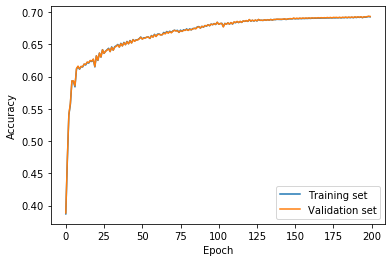

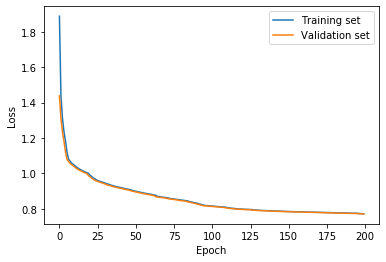

In [13]:
import matplotlib.pyplot as plt

df = pd.DataFrame()

plt.plot(df_risultati["acc_train"], label="Training set")
plt.plot(df_risultati["acc_val"], label="Validation set")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
#plt.savefig("Accuracy_NN_io.pdf")
plt.show()


plt.plot(df_risultati["loss_train"], label="Training set")
plt.plot(df_risultati["loss_val"], label="Validation set")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
#plt.savefig("Loss_NN_io.pdf")
plt.show()

CLASSE  1
range 0   51


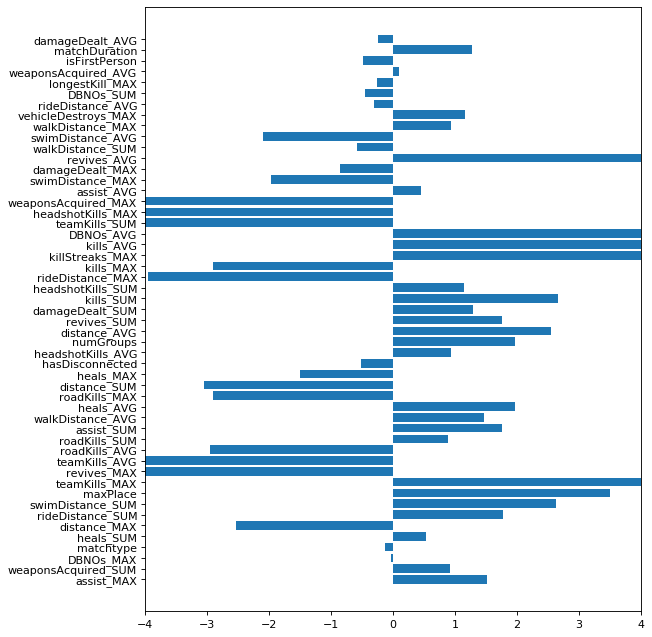

CLASSE  2
range 52   103


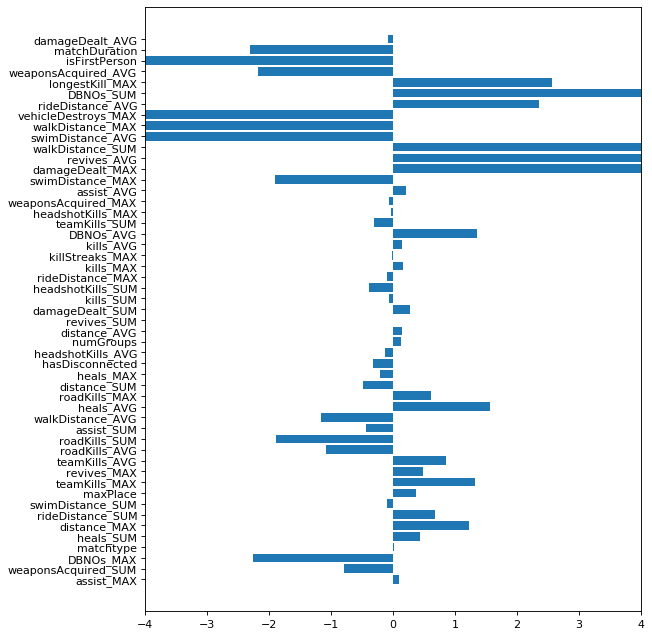

CLASSE  3
range 104   155


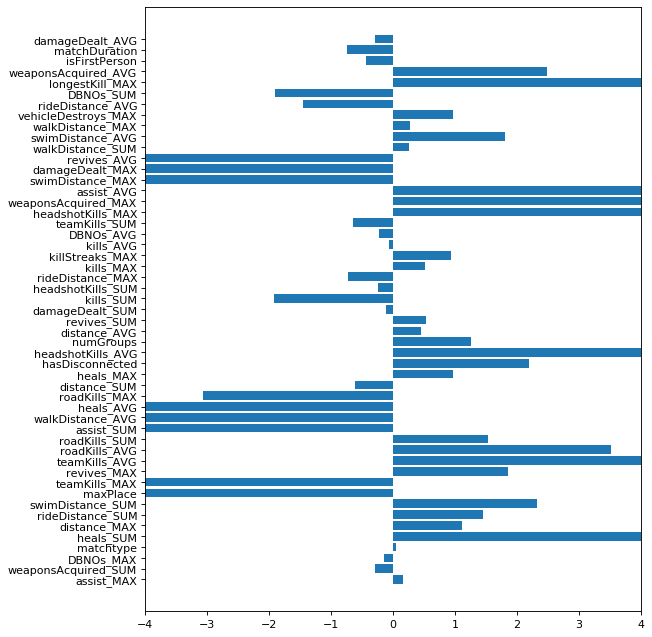

CLASSE  4
range 156   207


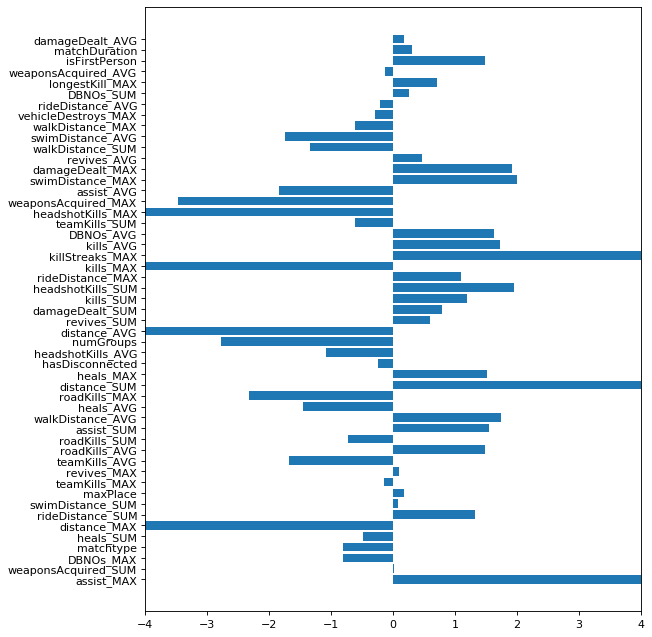

CLASSE  5
range 208   259


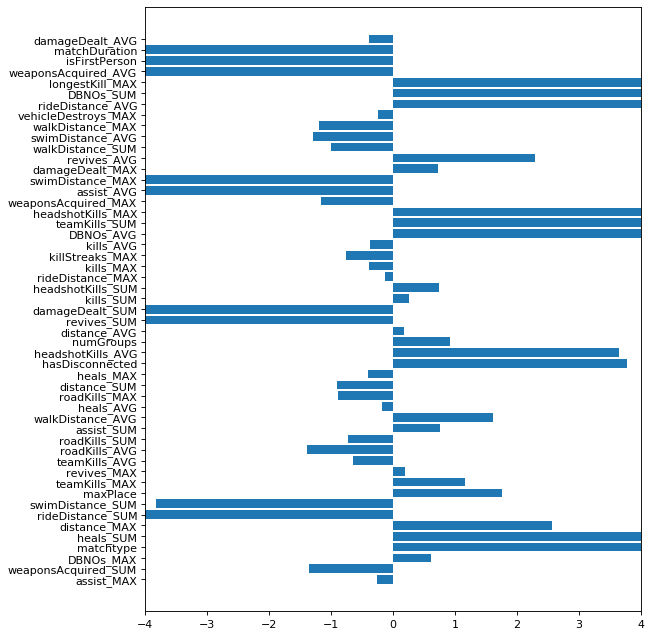

CLASSE  6
range 260   311


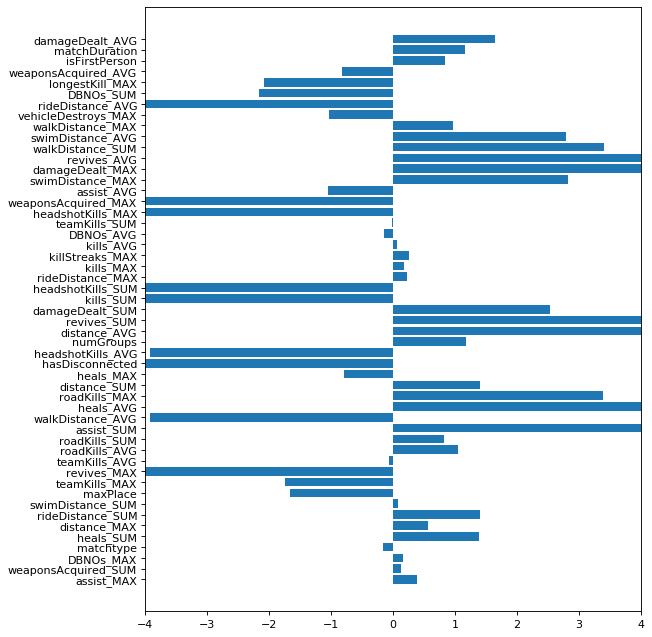

In [14]:
from matplotlib.pyplot import figure

for i in range(1, 7):
    print("CLASSE ", i)
    print("range", (i-1)*52, " ", (i*52-1))
    figure(figsize=(8, 10), dpi=80)
    #plt.barh(inputCols, list(map(lambda x: abs(x), model.weights[(i-1)*37:(i*37-1)])))
    plt.barh(inputCols, model.weights[(i-1)*52:(i*52-1)])
    plt.xlim([-4, 4])
    plt.show()

In [15]:
df_perVar = pd.DataFrame()

tmp = []

for i in range(1, 7):
    df_perVar[F'Classe_{i}'] = model.weights[(i-1)*52:(i*52-1)]
    tmp.append(model.weights[(i-1)*52:(i*52-1)])

In [16]:
df_perVar = pd.DataFrame(tmp, columns=inputCols) 

In [17]:
df_perVar

,assist_MAX,weaponsAcquired_SUM,DBNOs_MAX,matchtype,heals_SUM,distance_MAX,rideDistance_SUM,swimDistance_SUM,maxPlace,teamKills_MAX,...,swimDistance_AVG,walkDistance_MAX,vehicleDestroys_MAX,rideDistance_AVG,DBNOs_SUM,longestKill_MAX,weaponsAcquired_AVG,isFirstPerson,matchDuration,damageDealt_AVG
0,1.519327,0.915400,-0.033557,-0.129067,0.536048,-2.531124,1.774993,2.636604,3.496898,4.976402,...,-2.104048,0.940652,1.158281,-0.303850,-0.447831,-0.251952,0.095019,-0.490546,1.276670,-0.239886
1,0.099120,-0.786234,-2.255823,0.019833,0.438957,1.220870,0.671884,-0.099378,0.368190,1.326236,...,-8.040779,-20.664343,-8.269390,2.354914,5.685388,2.560427,-2.171934,-6.463888,-2.301031,-0.082732
2,0.162004,-0.284637,-0.149992,0.050375,6.780755,1.116223,1.443734,2.329155,-6.015693,-5.967089,...,1.799657,0.280071,0.963400,-1.445788,-1.910574,4.373837,2.478033,-0.438774,-0.745925,-0.285461
3,7.185626,0.023677,-0.808042,-0.814743,-0.484069,-5.315429,1.323783,0.080016,0.170876,-0.147736,...,-1.750359,-0.618228,-0.287198,-0.206817,0.250757,0.705240,-0.131465,1.487862,0.302939,0.179006
4,-0.255555,-1.349905,0.620509,4.607710,4.187132,2.566614,-7.968369,-3.830976,1.755618,1.168281,...,-1.291145,-1.187995,-0.236311,10.979608,20.336117,7.322548,-9.117240,-22.087162,-8.199522,-0.386459
5,0.388816,0.132614,0.166885,-0.161884,1.385359,0.556192,1.406568,0.077863,-1.661293,-1.743070,...,2.794417,0.967089,-1.025352,-4.585795,-2.167933,-2.077236,-0.815265,0.838622,1.156539,1.641339


In [18]:
df_perVar.describe()

,assist_MAX,weaponsAcquired_SUM,DBNOs_MAX,matchtype,heals_SUM,distance_MAX,rideDistance_SUM,swimDistance_SUM,maxPlace,teamKills_MAX,...,swimDistance_AVG,walkDistance_MAX,vehicleDestroys_MAX,rideDistance_AVG,DBNOs_SUM,longestKill_MAX,weaponsAcquired_AVG,isFirstPerson,matchDuration,damageDealt_AVG
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,1.516556,-0.224848,-0.410003,0.595371,2.140697,-0.397776,-0.224568,0.198881,-0.314234,-0.064496,...,-1.432043,-3.380459,-1.282762,1.132045,3.624321,2.105477,-1.610475,-4.525648,-1.418388,0.137634
std,2.842340,0.784116,1.016814,1.990668,2.780244,2.944295,3.810762,2.316810,3.281196,3.647730,...,3.809331,8.510489,3.520493,5.322841,8.668111,3.393626,3.977718,9.056333,3.579709,0.762575
min,-0.255555,-1.349905,-2.255823,-0.814743,-0.484069,-5.315429,-7.968369,-3.830976,-6.015693,-5.967089,...,-8.040779,-20.664343,-8.269390,-4.585795,-2.167933,-2.077236,-9.117240,-22.087162,-8.199522,-0.386459
25%,0.114841,-0.660834,-0.643529,-0.153680,0.463229,-1.759295,0.834859,-0.055067,-1.203251,-1.344236,...,-2.015626,-1.045553,-0.840814,-1.160303,-1.544888,-0.012654,-1.832767,-4.970553,-1.912254,-0.274067
50%,0.275410,-0.130480,-0.091775,-0.054617,0.960703,0.836208,1.365175,0.078939,0.269533,0.510272,...,-1.520752,-0.169079,-0.261754,-0.255334,-0.098537,1.632833,-0.473365,-0.464660,-0.221493,-0.161309
75%,1.236700,0.105379,0.116774,0.042740,3.486689,1.194709,1.434442,1.766870,1.408761,1.286747,...,1.026956,0.775507,0.663472,1.714481,4.326730,3.920485,0.038398,0.519273,0.943139,0.113571
max,7.185626,0.915400,0.620509,4.607710,6.780755,2.566614,1.774993,2.636604,3.496898,4.976402,...,2.794417,0.967089,1.158281,10.979608,20.336117,7.322548,2.478033,1.487862,1.276670,1.641339


In [19]:
df_perVar.describe().iloc[2]

assist_MAX             2.842340
weaponsAcquired_SUM    0.784116
DBNOs_MAX              1.016814
matchtype              1.990668
heals_SUM              2.780244
distance_MAX           2.944295
rideDistance_SUM       3.810762
swimDistance_SUM       2.316810
maxPlace               3.281196
teamKills_MAX          3.647730
revives_MAX            2.586370
teamKills_AVG          4.010711
roadKills_AVG          2.343826
roadKills_SUM          1.298724
assist_SUM             3.775756
walkDistance_AVG       2.804389
heals_AVG              3.222956
roadKills_MAX          2.508495
distance_SUM           3.057939
heals_MAX              1.120037
hasDisconnected        3.001546
headshotKills_AVG      3.225087
numGroups              1.684088
distance_AVG           3.504723
revives_SUM            3.303860
damageDealt_SUM        2.371293
kills_SUM              5.194599
headshotKills_SUM      2.361168
rideDistance_MAX       1.748681
kills_MAX              2.445479
killStreaks_MAX        4.007104
kills_AV

In [20]:
std = df_perVar.describe().iloc[2]

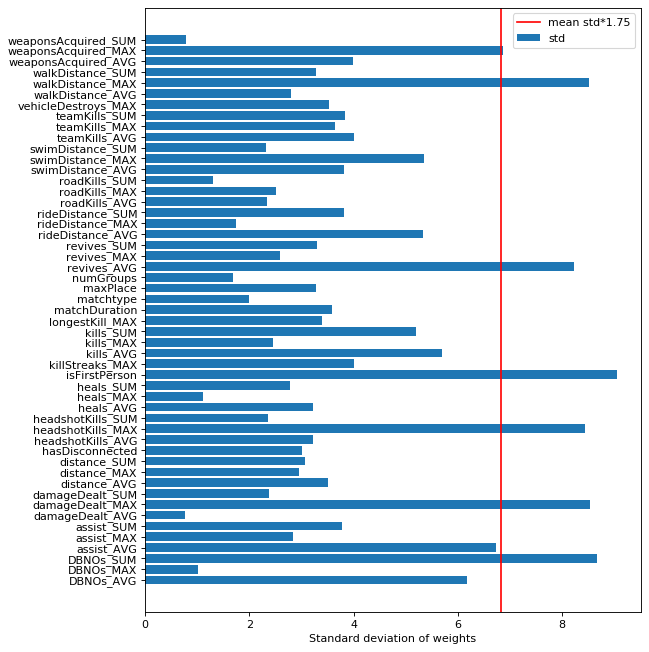

In [21]:
figure(figsize=(8, 10), dpi=80)

inputCols.sort()
std = std.sort_index()

plt.barh(std.index, std.values, label="std")

std_mean = 0

for i in std: std_mean +=i

plt.axvline(x=std_mean/len(std)*1.75, c='r', label="mean std*1.75")

plt.xlabel("Standard deviation of weights")
plt.legend()

#plt.savefig("std_NN_io.pdf", bbox='tight')

<BarContainer object of 51 artists>

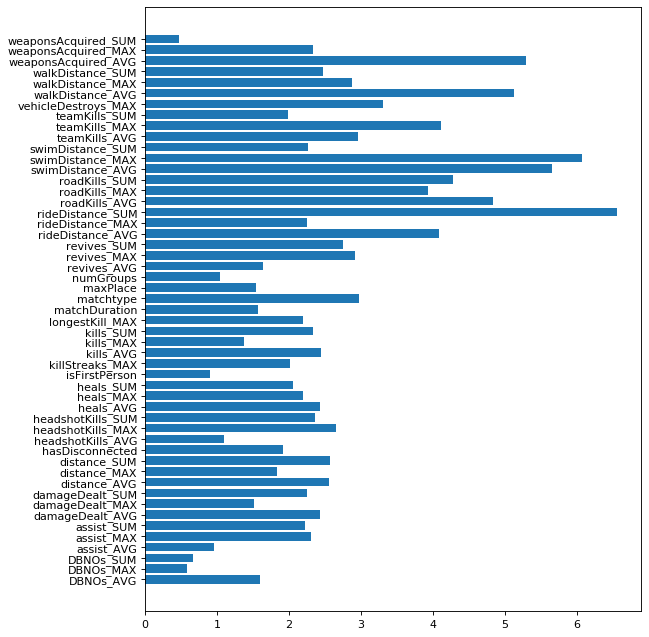

In [22]:
mean = df_perVar.abs().describe().iloc[1]

figure(figsize=(8, 10), dpi=80)

plt.barh(inputCols, mean)

<BarContainer object of 51 artists>

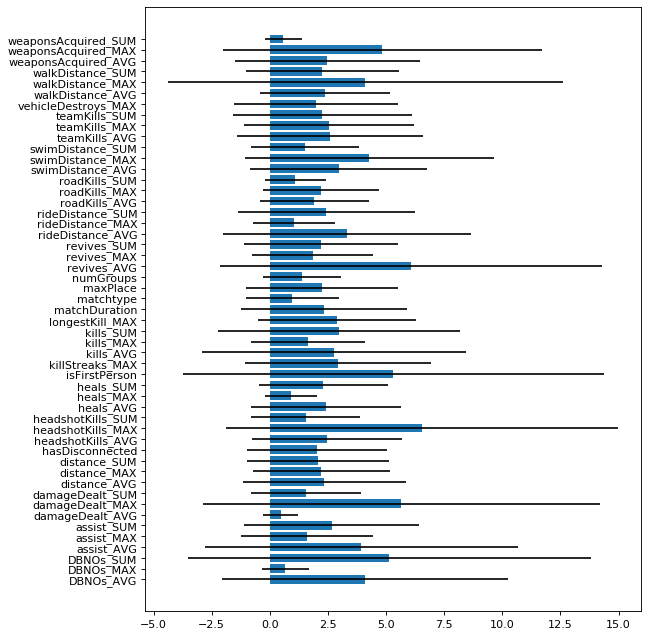

In [23]:
import numpy as np

figure(figsize=(8, 10), dpi=80)
#plt.barh(inputCols, std)
plt.barh(std.index, mean.sort_index(), xerr=np.array(std))

#plt.savefig("mean and std_NN_io.pdf")

In [24]:
predictions = model.transform(testing.withColumnRenamed( "features_scaled", "features"))
predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(51,[0,1,2,3,4,5,...|    1|[1.41979866769042...|[0.00962628079461...|       2.0|
|(51,[0,1,2,3,4,5,...|    1|[0.96334194800236...|[0.00138523606094...|       1.0|
|(51,[0,1,2,3,4,5,...|    4|[-11.145226864281...|[2.01861885981684...|       4.0|
|(51,[0,1,2,3,4,5,...|    3|[-4.0683813531493...|[7.71722574623201...|       3.0|
|(51,[0,1,2,3,4,5,...|    2|[-0.0964389400534...|[0.00513641658954...|       2.0|
|(51,[0,1,2,3,4,5,...|    1|[4.13834828270758...|[0.00745849253781...|       1.0|
|(51,[0,1,2,3,4,5,...|    2|[-0.4614892875983...|[0.00459208239602...|       2.0|
|(51,[0,1,2,3,4,5,...|    1|[14.1977122853957...|[0.03086153494196...|       1.0|
|(51,[0,1,2,3,4,5,...|    2|[2.85415818711075...|[0.02459775111566...|       1.0|
|(51,[0,1,2,3,4,

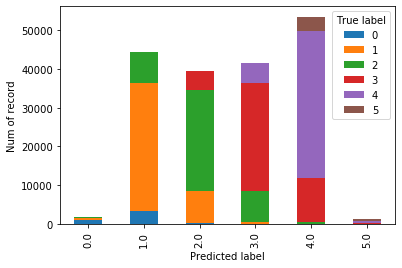

In [25]:
cross_tab = predictions.crosstab('prediction', 'label').toPandas().sort_values(by=["prediction_label"]).set_index('prediction_label')
cross_tab.plot.bar(stacked=True)

plt.ylabel("Num of record")
plt.xlabel("Predicted label")
plt.legend(title="True label")

#plt.savefig("confMatrixGraph_NN_io.pdf")

In [26]:
model.write().overwrite().save("NN.input_output_MinMax")

In [27]:
temp = output_scaled.rdd.map(lambda x:[float(y) for y in x['features_scaled']]).toDF(inputCols)

desc = temp.describe()
desc

DataFrame[summary: string, DBNOs_AVG: string, DBNOs_MAX: string, DBNOs_SUM: string, assist_AVG: string, assist_MAX: string, assist_SUM: string, damageDealt_AVG: string, damageDealt_MAX: string, damageDealt_SUM: string, distance_AVG: string, distance_MAX: string, distance_SUM: string, hasDisconnected: string, headshotKills_AVG: string, headshotKills_MAX: string, headshotKills_SUM: string, heals_AVG: string, heals_MAX: string, heals_SUM: string, isFirstPerson: string, killStreaks_MAX: string, kills_AVG: string, kills_MAX: string, kills_SUM: string, longestKill_MAX: string, matchDuration: string, matchtype: string, maxPlace: string, numGroups: string, revives_AVG: string, revives_MAX: string, revives_SUM: string, rideDistance_AVG: string, rideDistance_MAX: string, rideDistance_SUM: string, roadKills_AVG: string, roadKills_MAX: string, roadKills_SUM: string, swimDistance_AVG: string, swimDistance_MAX: string, swimDistance_SUM: string, teamKills_AVG: string, teamKills_MAX: string, teamKills

In [28]:
desc_df = desc.toPandas().set_index("summary")

std_data = desc_df.iloc[2]
std_data

DBNOs_AVG                0.05928249660566238
DBNOs_MAX                0.02599751536545333
DBNOs_SUM                0.04361365331263141
assist_AVG                0.4201038426609207
assist_MAX                0.0365586944748215
assist_SUM               0.05534459651871464
damageDealt_AVG          0.04725314456215206
damageDealt_MAX         0.009171888149984837
damageDealt_SUM           0.2914064274866636
distance_AVG             0.05856053565966715
distance_MAX            0.015714873968129137
distance_SUM            0.013774008665569822
hasDisconnected        0.0032691047242645386
headshotKills_AVG       0.005452197044910472
headshotKills_MAX          0.049182024387351
headshotKills_SUM        0.04475774824147045
heals_AVG                0.03773378109471484
heals_MAX               0.005289401892984059
heals_SUM               0.050389313509826665
isFirstPerson           0.041583271130932534
killStreaks_MAX          0.28228436643995286
kills_AVG               0.023816970839709493
kills_MAX 

In [29]:
std

DBNOs_AVG              6.164868
DBNOs_MAX              1.016814
DBNOs_SUM              8.668111
assist_AVG             6.722626
assist_MAX             2.842340
assist_SUM             3.775756
damageDealt_AVG        0.762575
damageDealt_MAX        8.533681
damageDealt_SUM        2.371293
distance_AVG           3.504723
distance_MAX           2.944295
distance_SUM           3.057939
hasDisconnected        3.001546
headshotKills_AVG      3.225087
headshotKills_MAX      8.432330
headshotKills_SUM      2.361168
heals_AVG              3.222956
heals_MAX              1.120037
heals_SUM              2.780244
isFirstPerson          9.056333
killStreaks_MAX        4.007104
kills_AVG              5.690873
kills_MAX              2.445479
kills_SUM              5.194599
longestKill_MAX        3.393626
matchDuration          3.579709
matchtype              1.990668
maxPlace               3.281196
numGroups              1.684088
revives_AVG            8.223857
revives_MAX            2.586370
revives_

In [30]:
tmp = []

for i in range(len(std_data)):
    tmp.append(float(std_data[i])*float(std[i]))

<BarContainer object of 51 artists>

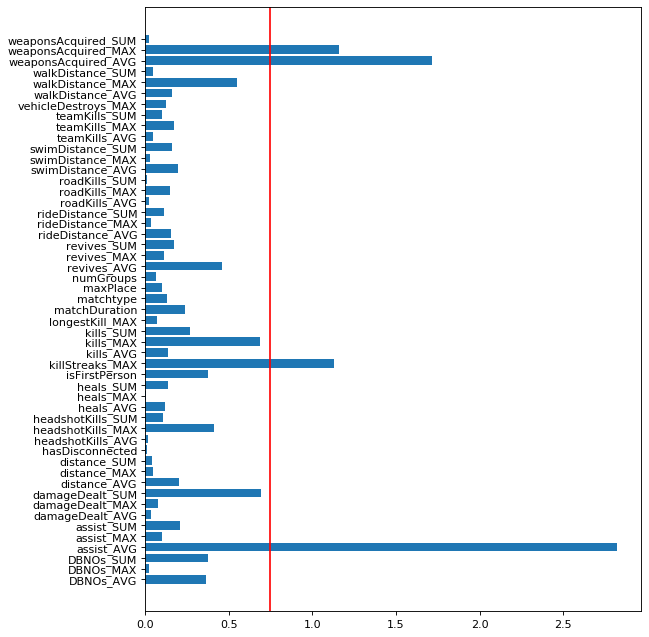

In [31]:
figure(figsize=(8, 10), dpi=80)

plt.axvline(x=0.75, c='r', label=".75")

plt.barh(std.index, tmp)

## Evaluation

In [32]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels_prob = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels_prob)

In [33]:
# Summary stats
print("Recall = %s" % (metrics.weightedRecall))
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

# Individual label stats
labels = [0.0, 1.0 ,2.0, 3.0, 4.0, 5.0]
for label in labels:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label)))
    
print('Confusion Matrix')
print(metrics.confusionMatrix().toArray())

Recall = 0.6941514228201208
Precision = 0.6843463869299939
F1 measure = 0.6832018723580362
Accuracy = 0.6941514228201208
Class 0.0 precision = 0.6043822276323798
Class 0.0 recall = 0.22964847363552265
Class 0.0 F1 Measure = 0.33283056812468576
Class 1.0 precision = 0.7436174038115786
Class 1.0 recall = 0.7809114724693776
Class 1.0 F1 Measure = 0.7618082816259338
Class 2.0 precision = 0.6605355830863165
Class 2.0 recall = 0.6114303135479937
Class 2.0 F1 Measure = 0.6350350740452066
Class 3.0 precision = 0.6721354919533584
Class 3.0 recall = 0.6228289503058445
Class 3.0 F1 Measure = 0.6465435331742023
Class 4.0 precision = 0.7060681380702312
Class 4.0 recall = 0.8689882006578191
Class 4.0 F1 Measure = 0.7791021384529727
Class 5.0 precision = 0.31715481171548116
Class 5.0 recall = 0.08991696322657176
Class 5.0 F1 Measure = 0.14011090573012938
Confusion Matrix
[[9.9300e+02 3.2200e+03 8.7000e+01 1.2000e+01 6.0000e+00 6.0000e+00]
 [6.0400e+02 3.3088e+04 8.2950e+03 3.5700e+02 2.7000e+01 0.000

In [34]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.setMetricName('f1')
f1 = evaluator.evaluate(predictions)

#print("Test Error = %g " % (1.0 - accuracy))
print("F1 = %g " % f1)

F1 = 0.683202 


In [35]:
evaluator.setMetricName('accuracy')
accuracy = evaluator.evaluate(predictions)
print("accuracy = %g " % accuracy)

accuracy = 0.694151 


## Sklearn metrics

In [36]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

In [38]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.23      0.33      4324
           1       0.74      0.78      0.76     42371
           2       0.66      0.61      0.64     42641
           3       0.67      0.62      0.65     44794
           4       0.71      0.87      0.78     43477
           5       0.32      0.09      0.14      4215

    accuracy                           0.69    181822
   macro avg       0.62      0.53      0.55    181822
weighted avg       0.68      0.69      0.68    181822



In [39]:
print(confusion_matrix(y_true, y_pred))

[[  993  3220    87    12     6     6]
 [  604 33088  8295   357    27     0]
 [   44  8061 26072  8090   358    16]
 [    2   125  4965 27899 11557   246]
 [    0     1    46  5101 37781   548]
 [    0     1     6    49  3780   379]]
